## make sure you have all libraries installed. 
use conda environment: /scratch/da2734/twitter/worldbank_twitter_environment.yml

# loading random and filtered samples

In [1]:
# filtered contains 0.8G of data!!
import time
start_time = time.time()
import pyarrow.parquet as pq
from glob import glob
import os
country_code = 'US'
month = '2012-1'
path_to_data = '/scratch/spf248/twitter/data/classification/US/filtered_10perct_sample//'
tweets_filtered=pq.ParquetDataset(glob(os.path.join(path_to_data,                                           
#                                            country_code,
#                                            month,
                                           '*.parquet'))).read().to_pandas()
tweets_filtered['tweet_id'] = tweets_filtered['tweet_id'].astype(int)
print('time taken to load keyword filtered sample:', str(time.time() - start_time), 'seconds')
print(tweets_filtered.shape)

time taken to load keyword filtered sample: 46.96626591682434 seconds
(9215824, 11)


In [2]:
# random contains 0.8G of data!!
import time
start_time = time.time()
import pyarrow.parquet as pq
from glob import glob
import os
country_code = 'US'
month = '2012-1'
path_to_data = '/scratch/spf248/twitter/data/classification/US/random_10perct_sample/'
tweets_random=pq.ParquetDataset(glob(os.path.join(path_to_data,                                           
#                                            country_code,
#                                            month,
                                           '*.parquet'))).read().to_pandas()
tweets_random['tweet_id'] = tweets_random['tweet_id'].astype(int)
print('time taken to load random sample:', str(time.time() - start_time), 'seconds')
print(tweets_random.shape)

time taken to load random sample: 31.48525094985962 seconds
(9468992, 11)


is_unemployed
time taken to load filtered sample: 3.1735503673553467 seconds (9215824, 3)
time taken to load random sample: 3.0406391620635986 seconds (9468992, 3)
time taken to merge: 7.715102434158325 seconds (9215824, 13)
time taken to merge: 7.726757526397705 seconds (9215824, 13)
time taken to dump: 10.60324215888977 seconds
is_unemployed
is_unemployed
filtered          neg_model  pos_model  \
5957351   0.050018   0.949982   
7417734   0.050064   0.949936   
1022274   0.050186   0.949814   
7432444   0.050309   0.949691   
4381332   0.050383   0.949617   

                                                      text  
5957351  People I went to high school with are getting ...  
7417734  I'm officially unemployed. Lol what do i do no...  
1022274  Being sick sucks... But hopefully by Thursday ...  
7432444  BROWN RECLUSE IN THE BATHROOM AT WORK LET'S JU...  
4381332     I'm unemployed after May 7th, Who wants me lol  
time taken to save csv: 4.245320081710815 seconds
is_unemployed
ra

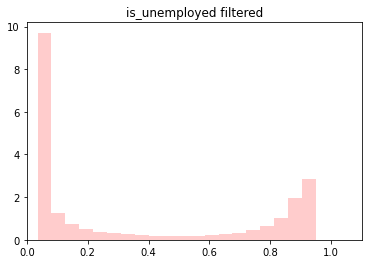

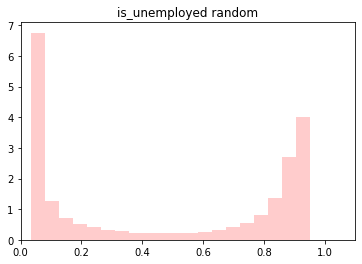

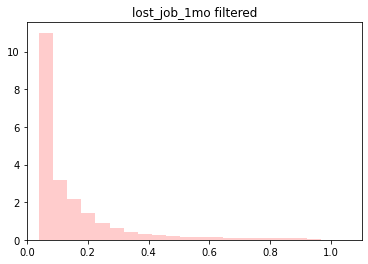

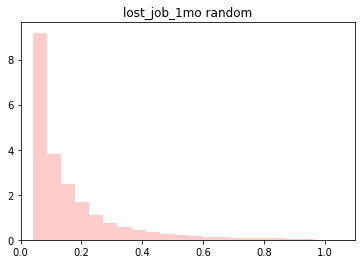

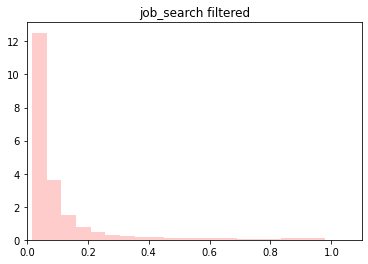

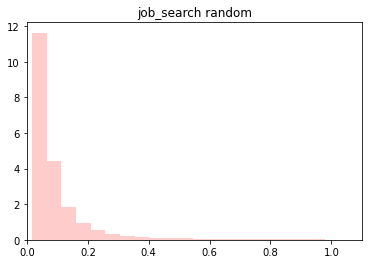

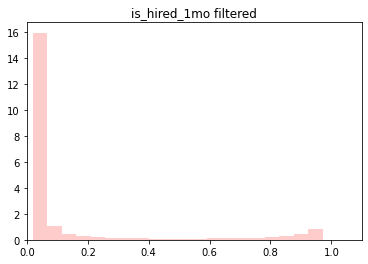

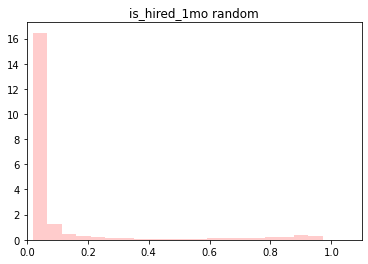

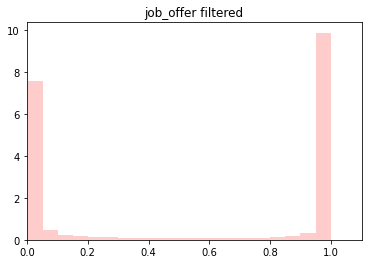

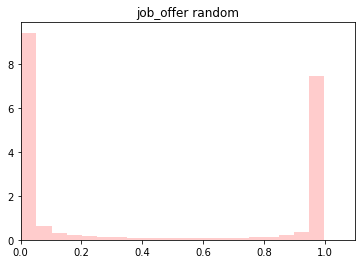

In [11]:
# all in one loop
import glob
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt

boundary = 0.725

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    start_time = time.time()
    model_output_path = '/scratch/da2734/twitter/jobs/running_on_200Msamples/pred_output_10pct_sample/{}/'.format(column)
    model_output_filtered = pd.concat([pd.read_csv(f) for f in glob.glob(model_output_path+'filtered*.csv')], ignore_index = True)
    print('time taken to load filtered sample:', str(time.time() - start_time), 'seconds', model_output_filtered.shape)


    start_time = time.time()
    model_output_random = pd.concat([pd.read_csv(f) for f in glob.glob(model_output_path+'random*.csv')], ignore_index = True)
    print('time taken to load random sample:', str(time.time() - start_time), 'seconds', model_output_random.shape)


    start_time = time.time()
    merged_filtered = pd.merge(model_output_filtered, tweets_filtered, how='inner', on = 'tweet_id')
    print('time taken to merge:', str(time.time() - start_time), 'seconds', merged_filtered.shape)

    start_time = time.time()
    merged_random = pd.merge(model_output_random, tweets_random, how='inner', on = 'tweet_id')
    print('time taken to merge:', str(time.time() - start_time), 'seconds', merged_filtered.shape)

    start_time = time.time()
    pickle.dump( merged_filtered, open( "./pickles/{}_merged_filtered.pkl".format(column), "wb" ) )
    pickle.dump( merged_random, open( "./pickles/{}_merged_random.pkl".format(column), "wb" ) )
    print('time taken to dump:', str(time.time() - start_time), 'seconds')

    merged_filtered = merged_filtered[['neg_model', 'pos_model', 'text']]
    merged_random   = merged_random[['neg_model', 'pos_model', 'text']]
    
    print(column)
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged_filtered['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
    plt.title(column+' filtered')
#     ax.set_yscale('log')
    plt.xlim(0,1.1)
    
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged_random['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
    plt.title(column+' random')
#     ax.set_yscale('log')
    plt.xlim(0,1.1)
    
    print(column)
    start_time = time.time()
    sort_merged_filtered = merged_filtered.sort_values(by=['pos_model'], ascending=False)
    sort_merged_filtered.head(500).to_csv('csv/filtered_{}_pos_500.csv'.format(column))
    print('filtered', sort_merged_filtered.head())
    
#     sort_merged_filtered = merged_filtered.sort_values(by=['pos_model'], ascending=True)
#     sort_merged_filtered.head(100).to_csv('csv/filtered_{}_neg_100.csv'.format(column))
#     print(sort_merged_filtered.head())
    print('time taken to save csv:', str(time.time() - start_time), 'seconds')

    print(column)
    start_time = time.time()
    sort_merged_random = merged_random.sort_values(by=['pos_model'], ascending=False)
    sort_merged_random.head(500).to_csv('csv/random_{}_pos_500.csv'.format(column))
    print('random', sort_merged_random.head())
    
#     sort_merged_random = merged_random.sort_values(by=['pos_model'], ascending=True)
#     sort_merged_random.head(100).to_csv('csv/random_{}_neg_100.csv'.format(column))
#     print(sort_merged_random.head())
    print('time taken to save csv:', str(time.time() - start_time), 'seconds')


    #### boundary save 
    
#     merged_filtered['dist_point{}'.format(boundary)] = abs(merged_filtered['pos_model'] - boundary)

#     start_time = time.time()
#     print(column, 'filtered subtraction time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_filtered = merged_filtered.sort_values(by=['dist_point{}'.format(boundary)], ascending=True)
#     print(column, 'filtered sorting time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_filtered[:100].to_csv('csv/boundary_filtered_{}_point_{}.csv'.format(column, boundary))
#     # print(all_filtered_boundary['text'])
#     print(column, 'filtered write csv time taken:', str(time.time() - start_time), 'seconds')


#     merged_random['dist_point{}'.format(boundary)] = abs(merged_random['pos_model'] - boundary)

#     start_time = time.time()
#     print(column, 'random subtraction time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_random = merged_random.sort_values(by=['dist_point{}'.format(boundary)], ascending=True)
#     print(column, 'random sorting time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_random[:100].to_csv('csv/boundary_random_{}_point_{}.csv'.format(column, boundary))
#     # print(all_random_boundary['text'])
#     print(column, 'random write csv time taken:', str(time.time() - start_time), 'seconds')    
    
    
#     break

In [ ]:
# entropy
import glob
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np

boundary = 0.5

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    start_time = time.time()
    model_output_path = '/scratch/da2734/twitter/running_on_200Msamples/pred_output/{}/'.format(column)
    model_output_filtered = pd.concat([pd.read_csv(f) for f in glob.glob(model_output_path+'filtered*.csv')], ignore_index = True)
    print('time taken to load filtered sample:', str(time.time() - start_time), 'seconds', model_output_filtered.shape)


    start_time = time.time()
    model_output_random = pd.concat([pd.read_csv(f) for f in glob.glob(model_output_path+'random*.csv')], ignore_index = True)
    print('time taken to load random sample:', str(time.time() - start_time), 'seconds', model_output_random.shape)


    start_time = time.time()
    merged_filtered = pd.merge(model_output_filtered, tweets_filtered, how='inner', on = 'tweet_id')
    print('time taken to merge:', str(time.time() - start_time), 'seconds', merged_filtered.shape)

    start_time = time.time()
    merged_random = pd.merge(model_output_random, tweets_random, how='inner', on = 'tweet_id')
    print('time taken to merge:', str(time.time() - start_time), 'seconds', merged_filtered.shape)

    start_time = time.time()
    pickle.dump( merged_filtered, open( "./top_tweets/{}_merged_filtered.pkl".format(column), "wb" ) )
    pickle.dump( merged_random, open( "./top_tweets/{}_merged_random.pkl".format(column), "wb" ) )
    print('time taken to dump:', str(time.time() - start_time), 'seconds')

    merged_filtered = merged_filtered[['neg_model', 'pos_model', 'text']]
    merged_random   = merged_random[['neg_model', 'pos_model', 'text']]
    
#     merged_random = merged_random[merged_random['pos_model'] > 0.5 ]

    merged_filtered['entropy'] = - merged_filtered['pos_model']*(np.log(merged_filtered['pos_model']))
    merged_random['entropy'] = - merged_random['pos_model']*(np.log(merged_random['pos_model']))
    
#     merged_filtered = merged_filtered[merged_filtered['pos_model'] > 0.5 ]

    
    print(column)
    fig = plt.figure()
    ax = plt.subplot(111)
#     plt.hist(merged_filtered['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
    plt.hist(merged_filtered['entropy'], bins=20, density = True, color = 'red', alpha = 0.2)    
    plt.title(column+' filtered')
#     ax.set_yscale('log')
#     plt.xlim(0,1.1)
    
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged_random['entropy'], bins=20, density = True, color = 'red', alpha = 0.2)
#     plt.hist(merged_random['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
    plt.title(column+' random')
#     ax.set_yscale('log')
#     plt.xlim(0,1.1)
    
#     print(column)
#     start_time = time.time()
#     sort_merged_filtered = merged_filtered.sort_values(by=['pos_model'], ascending=False)
#     sort_merged_filtered.head(100).to_csv('top_tweets/filtered_{}_pos_100.csv'.format(column))
#     print(sort_merged_filtered.head())
    
#     sort_merged_filtered = merged_filtered.sort_values(by=['pos_model'], ascending=True)
#     sort_merged_filtered.head(100).to_csv('top_tweets/filtered_{}_neg_100.csv'.format(column))
#     print(sort_merged_filtered.head())
#     print('time taken to save csv:', str(time.time() - start_time), 'seconds')

#     print(column)
#     start_time = time.time()
#     sort_merged_random = merged_random.sort_values(by=['pos_model'], ascending=False)
#     sort_merged_random.head(100).to_csv('top_tweets/random_{}_pos_100.csv'.format(column))
#     print(sort_merged_random.head())
    
#     sort_merged_random = merged_random.sort_values(by=['pos_model'], ascending=True)
#     sort_merged_random.head(100).to_csv('top_tweets/random_{}_neg_100.csv'.format(column))
#     print(sort_merged_random.head())
#     print('time taken to save csv:', str(time.time() - start_time), 'seconds')


#     merged_filtered['dist_point5'] = abs(merged_filtered['pos_model'] - boundary)

#     start_time = time.time()
#     print(column, 'filtered subtraction time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_filtered = merged_filtered.sort_values(by=['dist_point5'], ascending=True)
#     print(column, 'filtered sorting time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_filtered[:100].to_csv('top_tweets/filtered_{}_point5.csv'.format(column))
#     # print(all_filtered_boundary['text'])
#     print(column, 'filtered write csv time taken:', str(time.time() - start_time), 'seconds')


#     merged_random['dist_point5'] = abs(merged_random['pos_model'] - boundary)

#     start_time = time.time()
#     print(column, 'random subtraction time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_random = merged_random.sort_values(by=['dist_point5'], ascending=True)
#     print(column, 'random sorting time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_random[:100].to_csv('top_tweets/random_{}_point5.csv'.format(column))
#     # print(all_random_boundary['text'])
#     print(column, 'random write csv time taken:', str(time.time() - start_time), 'seconds')    
    
    
#     break